# Import libraries

In [14]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re

# Load data

In [15]:
mixed_cases

['mixed_01_pheno_linear']

In [16]:
from scripts.parse_vars import parse_variables, load_config
PATH_VARS = Path("../../geno_simulation.txt")
# Random seed for reproducibility of the flip step
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]);
# Build prefix pattern for filtering
prefix = f"G{G}_L{L}_c{c}_k{k}_M{M}"

# Filter only relevant directories
filtered = [d for d in os.listdir("simulation_data") if d.startswith(prefix)]
# Extract F values and mixed cases
F_values = []
mixed_cases = []

for d in filtered:
    # Check if F is present
    match_F = re.search(r"F([0-9.]+)", d)
    if match_F:
        F_values.append(float(match_F.group(1)))

    # Check if mixed is present
    match_mixed = re.search(r"(mixed_[^/]+)", d)
    if match_mixed:
        mixed_cases.append(match_mixed.group(1))
#base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_values[0]}/genotype"
base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_{mixed_cases[0]}"
path_geno = f"{base_path}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete.pkl"))

In [17]:
path_pcs = f"{base_path}/PCs"

In [18]:
het = (geno == 0).astype(int)

In [19]:
geno

,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,VR_391,VR_392,VR_393,VR_394,VR_395,VR_396,VR_397,VR_398,VR_399,VR_400
0,-1,0,1,-1,-1,-1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,-1,-1,1,-1,-1,-1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,1
2,-1,-1,1,-1,-1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,-1,-1,1,-1,-1,-1,1,1,1,0,...,1,0,1,1,1,1,1,1,1,1
4,-1,-1,0,-1,-1,-1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,-1,-1,1,1,1,-1,1,-1,-1,...,1,1,1,1,1,1,1,1,1,-1
1996,-1,-1,-1,1,1,1,-1,1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
1997,-1,-1,-1,1,1,1,-1,1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
1998,-1,-1,-1,1,1,1,-1,1,-1,-1,...,1,1,1,1,1,-1,1,1,1,1


In [36]:
import os, re

pc_files = [f for f in os.listdir(path_pcs) if re.match(r"^geno_\d", f)]
pc_files = sorted(pc_files, key=lambda x: int(re.search(r'geno_(\d+)_PCs', x).group(1)))

for pc_file in pc_files:
    path_pc = f"{path_pcs}/{pc_file}"

In [38]:
PCs = pd.read_pickle(path_pc)
common_idx = PCs.index.intersection(geno.index)
PCs = PCs.loc[common_idx]
geno = geno.loc[common_idx]
het = (geno == 0).astype(int)
pc_means = PCs.mean(axis=0)
PCs_c = PCs - pc_means  # (n, k)

In [39]:
# Calculate q_hat

In [40]:
n = PCs_c.shape[0]
X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)

B, residuals, rank, s = np.linalg.lstsq(X, geno.values, rcond=None)

# 4) Extract M_mean (length = n_snps) and weights
M_mean = pd.Series(B[0, :], index=geno.columns, name="maf_mean")           # (n_snps,)
W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=geno.columns)      # (k, n_snps)

# 5) Reconstruct genotypes for the observed samples
#    M_hat = 1·M_mean^T + PCs_c · W
q_hat  = X @ B
q_hat  = pd.DataFrame(q_hat , index=geno.index, columns=geno.columns)
q_hat = (1-q_hat)/2

In [41]:
q_hat

,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,VR_391,VR_392,VR_393,VR_394,VR_395,VR_396,VR_397,VR_398,VR_399,VR_400
0,0.752269,0.743038,0.224710,0.795142,1.078977,0.973181,0.013503,0.234755,-0.097780,0.284392,...,0.078557,0.128590,0.032246,0.008993,-0.022228,0.054400,0.058019,0.061875,0.045125,0.019076
1,0.969517,0.893208,0.413887,0.900088,1.020801,0.936930,0.139856,0.208990,0.040302,0.353708,...,0.115256,0.077164,0.043759,-0.046779,0.027122,0.011930,0.014170,0.079240,0.085253,-0.086931
2,0.901271,0.682095,0.379129,0.831346,0.897616,0.945673,0.138887,0.303061,0.070179,0.339200,...,0.102807,0.036656,-0.002379,0.059131,0.054981,0.098058,-0.009844,0.092793,0.048773,0.014286
3,1.006718,0.744053,0.435036,0.800878,0.888421,0.974591,0.034726,0.124749,-0.045779,0.462072,...,0.075354,0.171923,0.041427,0.025620,-0.058733,-0.004826,0.013035,0.059638,0.008056,0.039592
4,0.759799,0.615656,0.178926,1.007181,0.898216,1.064327,0.061218,0.174891,-0.051952,0.443978,...,0.049574,0.086039,0.023704,0.013266,0.002957,0.011229,0.019845,0.028605,0.025069,0.076488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.840991,0.863569,0.906164,0.034783,-0.081165,0.074567,0.881895,0.228831,0.981921,0.957507,...,0.032801,0.006796,0.068630,0.058884,0.068349,0.070721,0.094355,0.057498,0.059436,0.043675
1996,0.883277,0.907882,0.947835,-0.072057,-0.117268,-0.000750,0.753589,-0.203602,0.986789,1.151528,...,-0.015301,-0.021284,0.058239,0.174967,0.073964,0.100500,0.039326,0.017359,0.031677,0.103422
1997,0.772810,0.822314,0.886216,0.022220,0.057475,0.169521,1.040544,0.236477,0.882693,0.792452,...,0.033199,0.037050,0.094453,0.081565,0.077291,0.075767,0.041014,0.029930,0.045628,0.016704
1998,0.816046,0.984803,0.932009,-0.010653,0.071684,0.155120,0.943232,0.123645,0.976826,0.995108,...,0.004292,0.010841,-0.000214,0.022405,0.010705,0.084986,0.089757,0.075769,-0.012850,0.059505


In [42]:
# Calculate H_hat

In [43]:
n = PCs_c.shape[0]
X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)

B, residuals, rank, s = np.linalg.lstsq(X, het.values, rcond=None)

# 4) Extract M_mean (length = n_snps) and weights
het_mean = pd.Series(B[0, :], index=het.columns, name="het_mean")           # (n_snps,)
W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=het.columns)      # (k, n_snps)

# 5) Reconstruct genotypes for the observed samples
#    M_hat = 1·M_mean^T + PCs_c · W
het_hat  = X @ B
het_hat  = pd.DataFrame(het_hat , index=het.index, columns=het.columns)

In [44]:
# F_hat

In [45]:
denom = np.clip(2*q_hat*(1-q_hat), 1e-6, None)
F_hat = np.clip(1 - het_hat/denom, 0, 1)

In [47]:
pheno

NameError: name 'pheno' is not defined

In [46]:
F_hat.mean(axis=1)

0       0.315541
1       0.363030
2       0.262878
3       0.369172
4       0.257844
          ...   
1995    0.799564
1996    0.806506
1997    0.739414
1998    0.764976
1999    0.728967
Length: 2000, dtype: float64

In [34]:
F_hat.mean(axis=1)

0       0.335089
1       0.327393
2       0.290616
3       0.311231
4       0.243846
          ...   
1995    0.861769
1996    0.773725
1997    0.769291
1998    0.791268
1999    0.788428
Length: 2000, dtype: float64

In [13]:
def _center_scale(G):
    # G is n x m with entries in {-1,0,1}. Convert to 0/1/2 counts for scaling.
    G01 = G + 1.0
    p = np.nanmean(G01, axis=0) / 2.0              # allele frequency
    s = np.sqrt(2.0 * p * (1.0 - p))
    X = (G01 - 2.0*p) / np.where(s > 0, s, 1.0)    # EIGENSTRAT scaling
    X[:, s == 0] = 0.0
    return X, p, s

def compute_loco_pcs(G, chrom, k=10, random_state=0):
    """Compute LOCO PCs per chromosome/block."""
    chrom = np.asarray(chrom).astype(str)
    pcs_by_chrom = {}
    for c in np.unique(chrom):
        mask = chrom != c
        X_train, p_train, s_train = _center_scale(G[:, mask])
        pca = PCA(n_components=min(k, X_train.shape[1]),
                  svd_solver="randomized", random_state=random_state)
        pca.fit(X_train)

        # 🔧 Convert to 0/1/2 here as well
        G01_all = G[:, mask] + 1.0
        X_all = (G01_all - 2.0*p_train) / np.where(s_train>0, s_train, 1.0)
        X_all[:, s_train==0] = 0.0

        pcs_by_chrom[c] = pca.transform(X_all)
    return pcs_by_chrom

def fit_pf_for_snp(G_snp, X, cv_folds=5, ridge_alpha=1.0, logreg_C=1.0, random_state=0):
    g = G_snp.astype(float)                  # already in {-1,0,1}
    H = (G_snp == 0).astype(int)             # heterozygote is the 0 state
    n = len(g)

    # mean genotype -> p_hat
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    p_hat = np.zeros(n); g_pred = np.zeros(n)
    for tr, te in kf.split(X):
        model = Ridge(alpha=ridge_alpha, random_state=random_state)
        model.fit(X[tr], g[tr])
        mu = np.clip(model.predict(X[te]), -1, 1)
        g_pred[te] = mu
        p_hat[te] = np.clip((mu + 1)/2, 1e-6, 1-1e-6)

    # heterozygosity -> eta_hat
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    eta_hat = np.zeros(n)
    for tr, te in skf.split(X, H):
        clf = LogisticRegression(C=logreg_C, max_iter=500, solver="lbfgs")
        clf.fit(X[tr], H[tr])
        eta_hat[te] = clf.predict_proba(X[te])[:, 1]

    # F_hat
    denom = np.clip(2*p_hat*(1-p_hat), 1e-6, None)
    F_hat = np.clip(1 - eta_hat/denom, 0, 1)

    # probabilities
    q = 1 - p_hat; pq = p_hat*q
    P_AA = p_hat**2 + pq*F_hat
    P_Aa = 2*pq*(1 - F_hat)
    P_aa = q**2 + pq*F_hat
    Z = P_AA + P_Aa + P_aa
    P = np.vstack([P_AA/Z, P_Aa/Z, P_aa/Z]).T  # columns [AA, Aa, aa]

    # metrics with classes mapped from {-1,0,1} -> {aa=0, Aa=1, AA=2}
    y = np.where(G_snp == -1, 0, np.where(G_snp == 0, 1, 2))
    P_for_logloss = np.stack([P[:,2], P[:,1], P[:,0]], axis=1)  # order [aa, Aa, AA]
    ll = log_loss(y, P_for_logloss, labels=[0,1,2])
    Y = np.stack([y==2, y==1, y==0], axis=1).astype(float)      # align to [AA, Aa, aa]
    brier = np.mean((P - Y)**2)
    r2_g = 1 - np.sum((g - g_pred)**2) / (np.sum((g - g.mean())**2) + 1e-12)

    return dict(p_hat=p_hat, F_hat=F_hat, probs=P, g_pred=g_pred,
                logloss=ll, brier=brier, r2_g=r2_g)

def multiclass_ece(P, y, n_bins=20):
    """Expected Calibration Error, macro-averaged across 3 classes."""
    y = y.astype(int)
    Y = np.stack([y==2, y==1, y==0], axis=1).astype(float)
    n = len(y)
    eces = []
    for c in range(3):
        p = P[:,c]; t = Y[:,c]
        edges = np.linspace(0,1,n_bins+1)
        idx = np.digitize(p, edges)-1
        idx = np.clip(idx,0,n_bins-1)
        ece_c=0
        for b in range(n_bins):
            m = idx==b
            if m.sum()==0: continue
            conf = p[m].mean(); acc = t[m].mean()
            ece_c += (m.sum()/n)*abs(conf-acc)
        eces.append(ece_c)
    return np.mean(eces)

def assign_snps_to_chromosomes(
    cols,
    n_chroms=22,
    maf_bins="quantile",      # "quantile" or a list of bin edges, e.g. [0, .01, .05, .1, .5]
    n_quantile_bins=10,       # if maf_bins="quantile"
    stratify_by=("prefix","maf_bin"),  # you can change to ("maf_bin",) or ("prefix",) if desired
    random_state=None
):
    """
    Assign SNP columns to chromosomes with stratified balance.

    Parameters
    ----------
    cols : sequence of str
        Column names like 'C_1_MAF_0.500' or 'VR_39991_MAF_0.042'.
    n_chroms : int
        Number of chromosomes (labels will be 1..n_chroms).
    maf_bins : "quantile" or list of float
        If "quantile", compute quantile-based MAF bins (n_quantile_bins).
        If list, treated as explicit bin edges for pd.cut (must include min and max bounds).
    n_quantile_bins : int
        Number of quantile bins when maf_bins="quantile".
    stratify_by : tuple of {"prefix","maf_bin"}
        Strata used for balancing; default balances across source prefix and MAF spectrum.
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    list[int]
        Chromosome assignments aligned to input `cols`, e.g., [1,1,1,2,2,5,...].
    """
    rng = np.random.default_rng(random_state)
    # Parse prefix and MAF
    pat = re.compile(r'^(?P<prefix>[A-Za-z]+)_(?:\d+)_MAF_(?P<maf>[0-9.]+)$')
    parsed = []
    for i, c in enumerate(cols):
        m = pat.match(c)
        if not m:
            raise ValueError(f"Column name does not match expected pattern: {c}")
        prefix = m.group("prefix")
        maf = float(m.group("maf"))
        parsed.append((i, c, prefix, maf))
    df = pd.DataFrame(parsed, columns=["idx","col","prefix","maf"])

    # Build MAF bins
    if maf_bins == "quantile":
        # quantile cuts ensure each bin has ~equal counts
        # clip duplicates if MAF has many ties at extremes
        q = np.linspace(0, 1, n_quantile_bins + 1)
        edges = np.unique(np.quantile(df["maf"].to_numpy(), q, method="nearest"))
        # If duplicates collapsed too much, fall back to uniform edges
        if len(edges) < 3:
            edges = np.linspace(df["maf"].min(), df["maf"].max(), n_quantile_bins + 1)
        df["maf_bin"] = pd.cut(df["maf"], bins=edges, include_lowest=True, duplicates="drop")
    else:
        edges = maf_bins
        df["maf_bin"] = pd.cut(df["maf"], bins=edges, include_lowest=True)

    # Define strata keys
    def strata_key(row):
        key = []
        for dim in stratify_by:
            key.append(row[dim])
        return tuple(key) if len(key) > 1 else key[0]

    df["stratum"] = df.apply(strata_key, axis=1)

    # Round-robin allocation within each stratum to balance across chromosomes
    assignment = np.zeros(len(df), dtype=int)  # to be filled with 1..n_chroms
    for stratum, g in df.groupby("stratum"):
        idxs = g.index.to_numpy()
        # shuffle indices within stratum
        shuffled = idxs.copy()
        rng.shuffle(shuffled)
        # assign in cycles 1..n_chroms
        for j, ridx in enumerate(shuffled):
            assignment[ridx] = (j % n_chroms) + 1

    # Return aligned to original order of `cols`
    out = assignment[df.sort_values("idx").index.to_numpy()].tolist()
    return out

In [20]:
G = np.array(geno)
# Example usage
chrom = np.array(assign_snps_to_chromosomes(list(geno.columns), n_chroms=22, random_state=42))
pcs_by_chrom = compute_loco_pcs(G, chrom, k=10)

# Pick a SNP
j = 123  # SNP index
X = pcs_by_chrom[str(chrom[j])]
res = fit_pf_for_snp(G[:,j], X)
y012 = np.where(G[:, j] == -1, 0, np.where(G[:, j] == 0, 1, 2))
ece = multiclass_ece(res["probs"], y012)

print("Brier:", res["brier"], "LogLoss:", res["logloss"], "R2_g:", res["r2_g"])
print("ECE:", ece)

Brier: 0.10215700632185493 LogLoss: 0.645734286920806 R2_g: 0.6837599677073469
ECE: 0.056672912210875816


/tmp/ipykernel_2347/3055216028.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby(["k","maf_bin"]).agg(**{f"{c}_median": (c, "median") for c in metric_cols}).reset_index()


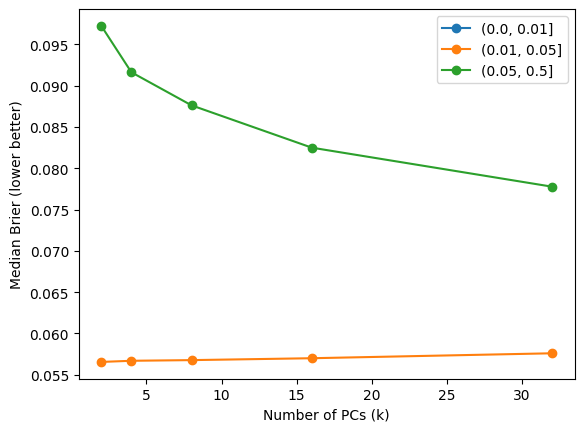

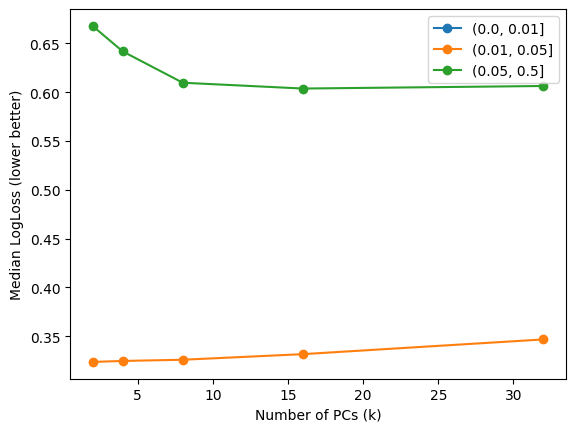

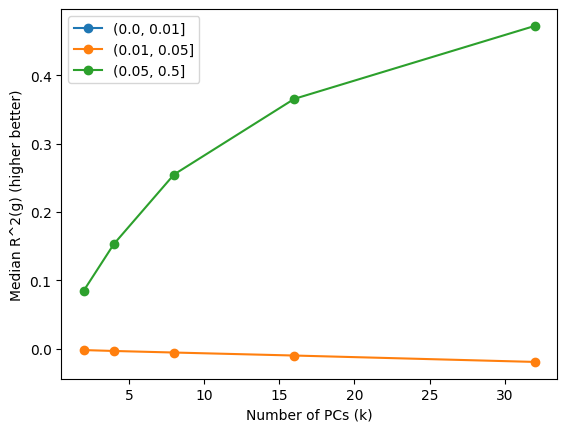

In [23]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- helpers ---
def maf_from_minus101(G_col):
    # G in {-1,0,1} → convert to {0,1,2} and compute MAF
    p = (G_col.mean() + 1.0) / 2.0  # allele freq
    return min(p, 1 - p)

def summarize_by_maf(df, maf_edges=(0.0, 0.01, 0.05, 0.5), metric_cols=("brier","logloss","r2_g")):
    edges = np.asarray(maf_edges)
    labels = [f"({edges[i]:.2f},{edges[i+1]:.2f}]" for i in range(len(edges)-1)]
    bins = pd.IntervalIndex.from_tuples(list(zip(edges[:-1], edges[1:])), closed='right')
    df = df.copy()
    df["maf_bin"] = pd.cut(df["maf"], bins=bins, labels=labels, include_lowest=True)
    agg = {c: ("median") for c in metric_cols}
    out = df.groupby(["k","maf_bin"]).agg(**{f"{c}_median": (c, "median") for c in metric_cols}).reset_index()
    return out

def plot_metric(summary, col, ylabel):
    for b in summary["maf_bin"].unique():
        sub = summary[summary["maf_bin"]==b].sort_values("k")
        plt.plot(sub["k"], sub[col], marker="o", label=str(b))
    plt.xlabel("Number of PCs (k)"); plt.ylabel(ylabel); plt.legend(); plt.show()

# --- sweep over k ---
rng = np.random.RandomState(1)
snp_subset = rng.choice(G.shape[1], size=1000, replace=False)   # adjust for speed/precision
k_list = [2, 4, 8, 16, 32]                                      # the ks to test

rows = []
for k in k_list:
    pcs_by_chrom = compute_loco_pcs(G, chrom, k=k)
    for j in snp_subset:
        X = pcs_by_chrom[str(chrom[j])]
        res = fit_pf_for_snp(G[:, j], X)
        maf = maf_from_minus101(G[:, j])
        rows.append({
            "k": k,
            "snp": int(j),
            "maf": maf,
            "brier": res["brier"],
            "logloss": res["logloss"],
            "r2_g": res["r2_g"]
        })

df = pd.DataFrame(rows)
summary = summarize_by_maf(df, maf_edges=(0.0, 0.01, 0.05, 0.5))

# --- visualize ---
plot_metric(summary, "brier_median",  "Median Brier (lower better)")
plot_metric(summary, "logloss_median","Median LogLoss (lower better)")
plot_metric(summary, "r2_g_median",   "Median R^2(g) (higher better)")


In [4]:
nrs_pcs = list(set([int(f.split("_")[1]) for f in os.listdir(f"simulation_data//G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs")]))

In [5]:
nrs_pcs

[1, 35, 100, 5, 40, 15, 50]

In [6]:
os.makedirs(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/",exist_ok = True)

In [7]:
geno

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.500,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_39991_MAF_0.042,VR_39992_MAF_0.042,VR_39993_MAF_0.041,VR_39994_MAF_0.041,VR_39995_MAF_0.041,VR_39996_MAF_0.041,VR_39997_MAF_0.040,VR_39998_MAF_0.040,VR_39999_MAF_0.039,VR_40000_MAF_0.038
0,-1,1,1,-1,0,-1,-1,-1,-1,-1,...,1,1,1,1,1,0,1,1,1,1
1,-1,1,1,-1,1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,-1,0,-1,-1,-1,-1,-1,...,1,1,0,1,1,1,1,1,1,1
3,-1,1,1,-1,1,-1,-1,-1,0,-1,...,1,1,1,1,0,0,1,1,1,1
4,-1,1,1,-1,1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,-1,-1,1,-1,1,1,1,1,1,...,1,1,1,1,0,1,0,1,1,0
1996,1,-1,-1,1,-1,1,1,1,1,1,...,1,0,1,1,1,0,1,1,1,1
1997,1,-1,-1,0,-1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1998,1,-1,-1,1,-1,1,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1


In [8]:
def column_chunks(df: pd.DataFrame,
                  max_cols: int = 4000,
                  seed: int = 42,
                  return_numpy: bool = False,
                  dtype=np.int8):
    """
    Yields randomized column chunks of size <= max_cols.
    Casting to int8 keeps genotype encodings (-1,0,1) compact.
    """
    cols = df.columns.to_numpy()
    rng = np.random.default_rng(seed)
    perm = rng.permutation(cols)  # randomized column order
    
    for start in range(0, len(perm), max_cols):
        block_cols = perm[start:start + max_cols]
        chunk_df = df.loc[:, block_cols]
        if dtype is not None:
            # downcast without copying if already int8-compatible
            chunk_df = chunk_df.astype(dtype, copy=False)
        yield chunk_df.to_numpy() if return_numpy else chunk_df

# --- Example usage ---
# geno is your (2000 x 40000) DataFrame

# 1) Get a list of 10 DataFrame chunks (each ~4000 cols)
chunks_df = list(column_chunks(geno, max_cols=4000, seed=123, return_numpy=False))


In [9]:


# --------- small helpers ---------

def make_projector(pcs_df: pd.DataFrame,
                   add_intercept: bool = True,
                   ridge_alpha: float | None = 1e-6,
                   dtype=np.float32):
    """Precompute A_aug and M = (A' A + αI)^(-1) A' once per PC set."""
    A = pcs_df.astype(dtype, copy=False).values
    n, k = A.shape
    if add_intercept:
        A_aug = np.concatenate([A, np.ones((n, 1), dtype=dtype)], axis=1)
    else:
        A_aug = A

    AtA = A_aug.T @ A_aug
    if ridge_alpha is not None and ridge_alpha > 0:
        AtA = AtA + ridge_alpha * np.eye(AtA.shape[0], dtype=AtA.dtype)

    # pinv is robust for tiny k
    M = np.linalg.pinv(AtA) @ A_aug.T        # (k+q, n)
    return A_aug, M

def apply_projector(A_aug, M, target_df: pd.DataFrame,
                    block_cols: int = 20000,
                    dtype=np.float32) -> pd.DataFrame:
    """Stream target_df through (A_aug, M) in column blocks."""
    cols = target_df.columns
    out_blocks = []
    for start in range(0, len(cols), block_cols):
        end = start + block_cols
        blk_cols = cols[start:end]
        B_blk = target_df[blk_cols].astype(dtype, copy=False).values   # (n, b)
        T = M @ B_blk                                                  # (k+q, b)
        Bhat_blk = A_aug @ T                                           # (n, b)
        out_blocks.append(pd.DataFrame(Bhat_blk, index=target_df.index, columns=blk_cols))
    return pd.concat(out_blocks, axis=1)

# --------- your loop, swapped to OLS ---------

for i, geno in enumerate(chunks_df):
    # build targets once per chunk
    minor = (geno == -1).astype(np.float32)
    het   = (geno ==  0).astype(np.float32)
    major = (geno ==  1).astype(np.float32)
    print(i)

    for nr_pcs in nrs_pcs:
        pcs_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl"
        geno_pcs = pd.read_pickle(pcs_path)

        # make sure rows align (important if indexing differs)
        if not geno_pcs.index.equals(geno.index):
            geno_pcs = geno_pcs.loc[geno.index]

        # Precompute projector once and reuse for all targets
        A_aug, M_1 = make_projector(geno_pcs, add_intercept=True, ridge_alpha=1e-6, dtype=np.float32)

        # Reconstruct each target in blocks (no massive matrices in memory)
        geno_reconstruct  = apply_projector(A_aug, M_1, geno,  block_cols=20000)
        min_reconstruct   = apply_projector(A_aug, M_1, minor, block_cols=20000)
        het_reconstruct   = apply_projector(A_aug, M_1, het,   block_cols=20000)
        major_reconstruct = apply_projector(A_aug, M_1, major, block_cols=20000)

        # Save
        outdir = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct"
        os.makedirs(outdir, exist_ok=True)
        geno_reconstruct.to_pickle (f"{outdir}/chunk_{i}_geno_reconstruct_{nr_pcs}_PCs.pkl")
        min_reconstruct.to_pickle  (f"{outdir}/chunk_{i}_minor_reconstruct_{nr_pcs}_PCs.pkl")
        het_reconstruct.to_pickle  (f"{outdir}/chunk_{i}_het_reconstruct_{nr_pcs}_PCs.pkl")
        major_reconstruct.to_pickle(f"{outdir}/chunk_{i}_major_reconstruct_{nr_pcs}_PCs.pkl")

        # Light cleanup
        del A_aug, M_1, geno_reconstruct, min_reconstruct, het_reconstruct, major_reconstruct
        gc.collect()


0
1
2
3
4
5
6
7
8
9


In [11]:
min_reconstruct = pd.read_pickle(f"{outdir}/chunk_{i}_minor_reconstruct_{nr_pcs}_PCs.pkl")
het_reconstruct = pd.read_pickle(f"{outdir}/chunk_{i}_het_reconstruct_{nr_pcs}_PCs.pkl")
major_reconstruct = pd.read_pickle(f"{outdir}/chunk_{i}_major_reconstruct_{nr_pcs}_PCs.pkl")

In [51]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))
pattern1 = re.compile(r"_reconstruct_(\d+)_PCs")
pattern2 = re.compile(r"chunk_(\d+)_")
for nr_pcs in nrs_pcs:
    list_of_chunks = [f for f in os.listdir(outdir) if (m := pattern1.search(f)) and m.group(1) == str(nr_pcs)]
    chunk_indexes = sorted({int(pattern2.search(f).group(1)) for f in list_of_chunks})
    minors = []
    hets = []
    majors = []
    genos_rec = []
    for i in chunk_indexes:
        minor = pd.read_pickle(f"{outdir}/chunk_{i}_minor_reconstruct_{nr_pcs}_PCs.pkl")
        het = pd.read_pickle(f"{outdir}/chunk_{i}_het_reconstruct_{nr_pcs}_PCs.pkl")
        major = pd.read_pickle(f"{outdir}/chunk_{i}_major_reconstruct_{nr_pcs}_PCs.pkl")
        geno_rec = pd.read_pickle(f"{outdir}/chunk_{i}_geno_reconstruct_{nr_pcs}_PCs.pkl")
        minors.append(minor)
        hets.append(het)
        majors.append(major)
        genos_rec.append(geno_rec)
    
    majors_df = pd.concat(majors, axis=1)
    majors_df = majors_df.reindex(columns=geno.columns)
    majors_df.to_pickle(f"{outdir}/major_reconstruct_{nr_pcs}_PCs.pkl")

    minors_df = pd.concat(minors, axis=1)
    minors_df = minors_df.reindex(columns=geno.columns)
    minors_df.to_pickle(f"{outdir}/minor_reconstruct_{nr_pcs}_PCs.pkl")

    hets_df = pd.concat(hets, axis=1)
    hets_df = hets_df.reindex(columns=geno.columns)
    hets_df.to_pickle(f"{outdir}/het_reconstruct_{nr_pcs}_PCs.pkl")

    genos_df = pd.concat(genos_rec, axis=1)
    genos_df = genos_df.reindex(columns=geno.columns)
    genos_df.to_pickle(f"{outdir}/geno_reconstruct_{nr_pcs}_PCs.pkl")

    for i in chunk_indexes:
        os.remove(f"{outdir}/chunk_{i}_minor_reconstruct_{nr_pcs}_PCs.pkl")
        os.remove(f"{outdir}/chunk_{i}_het_reconstruct_{nr_pcs}_PCs.pkl")
        os.remove(f"{outdir}/chunk_{i}_major_reconstruct_{nr_pcs}_PCs.pkl")
        os.remove(f"{outdir}/chunk_{i}_geno_reconstruct_{nr_pcs}_PCs.pkl")
    

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting toolkit
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys
import gc
import re
from collections import defaultdict

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss